In [168]:
import os
import configparser

import geopandas as gpd
from shapely.geometry import Point, Polygon

import requests
import pandas as pd

import matplotlib.pyplot as plt
from matplotlib.lines import Line2D

In [5]:
#set filepaths
project_root = os.path.abspath(os.getcwd())
root = os.path.abspath(os.path.join(os.getcwd(), "..", ".."))
config_file =  os.path.join(root, "config.cfg")

# geodata for shapefiles
config = configparser.ConfigParser()
config.read(config_file)
gdata_root = config["geodata"]["path"]

# Get data

## Basemap

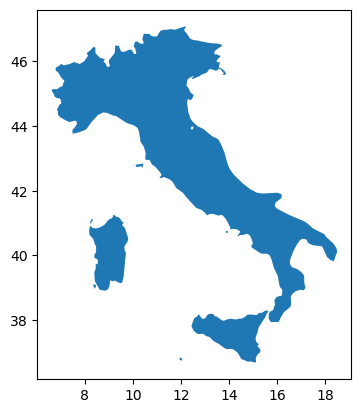

In [15]:
# Load map of Italy
world = gpd.GeoDataFrame.from_file(os.path.join(gdata_root, "natural-earth\\ne_50m_admin_0_countries\\ne_50m_admin_0_countries.shp"))
italy = world[world["SOVEREIGNT"]=="Italy"]
italy.plot()

In [16]:
italy.crs

<Geographic 2D CRS: EPSG:4326>
Name: WGS 84
Axis Info [ellipsoidal]:
- Lat[north]: Geodetic latitude (degree)
- Lon[east]: Geodetic longitude (degree)
Area of Use:
- name: World.
- bounds: (-180.0, -90.0, 180.0, 90.0)
Datum: World Geodetic System 1984 ensemble
- Ellipsoid: WGS 84
- Prime Meridian: Greenwich

## Gelaterias

In [18]:
# get gelaterias from OSM

#get data from OSM using Overpass API
overpass_url = "http://overpass-api.de/api/interpreter"
overpass_query = """
[out:json];
area[name="Italia"][admin_level=2]->.searchArea;

(node["amenity"="ice_cream"](area.searchArea); 
way["amenity"="ice_cream"](area.searchArea);
rel["amenity"="ice_cream"](area.searchArea);
node["shop"="ice_cream"](area.searchArea); 
way["shop"="ice_cream"](area.searchArea);
rel["shop"="ice_cream"](area.searchArea);
);
out center;
"""
response = requests.get(overpass_url, params={'data': overpass_query})
data = response.json()

In [23]:
#convert json into dataframe
df_dict = {"id":[], "type": [], "lat":[], "lon": [],"name":[], "shop":[], "amenity":[]}

for element in data['elements']:
    df_dict["id"].append(element["id"])
    df_dict["type"].append(element["type"])
    
    for tag in ["name", "shop", "amenity"]:
        try:
            df_dict[tag].append(element["tags"][tag])
        except KeyError:
            df_dict[tag].append("") 
    if element["type"]=="node":
        df_dict["lat"].append(element["lat"])
        df_dict["lon"].append(element["lon"])
    else:
        df_dict["lat"].append(element["center"]["lat"])
        df_dict["lon"].append(element["center"]["lon"])
        
df = pd.DataFrame.from_dict(df_dict)

# convert into geodataframe
geometry = [Point(xy) for xy in zip(df['lon'].astype(float), df['lat'].astype(float))]
gdf = gpd.GeoDataFrame(df, crs = 'EPSG:4326', geometry = geometry)

In [61]:
name_cat = []
gdf["name_clean"] = gdf["name"].str.lower().str.replace("&", "e")

for i,name in enumerate(gdf["name_clean"]):
    if "gelateria" in name:
        name_cat.append("Gelateria")
    elif ("gelato" in name) | ("gelati" in name) :
        name_cat.append("Gelato")
    else:
        name_cat.append("Other")

gdf["name_group"] = name_cat
gdf["name_group"].value_counts()

Other        2761
Gelateria    1522
Gelato        580
Name: name_group, dtype: int64

In [48]:
# top names
gdf["name_clean"].value_counts().to_frame().head(12)

,name_clean
,546
gelateria,56
crema e cioccolato,53
grom,35
gelateria artigianale,21
venchi,18
la bottega del gelato,18
yogorino,17
la gelateria,16
la romana,15


# Visualise

In [237]:
from matplotlib import font_manager
#font_manager.findSystemFonts(fontpaths=None, fontext='ttf')

In [244]:
bg_color="#163555"
font_color="#eaeaea"
colrs = {"Gelateria": "#D9D66A", "Gelato": "#D89EA9", "Other":"#D89EA9" }
#colrs = {"Gelateria": "#8FD2DD", "Gelato": "#D89EA9", "Other":"#D9D66A" } # tested different colours

#set font styles
subtitle_font = font_manager.FontProperties(fname='C:\\Windows\\Fonts\\Inter-Medium.otf')
title_font = font_manager.FontProperties(fname='C:\\Windows\\Fonts\\ArtYard Thick.ttf')
label_font = font_manager.FontProperties(fname='C:\\Windows\\Fonts\\Inter-Thin.otf')

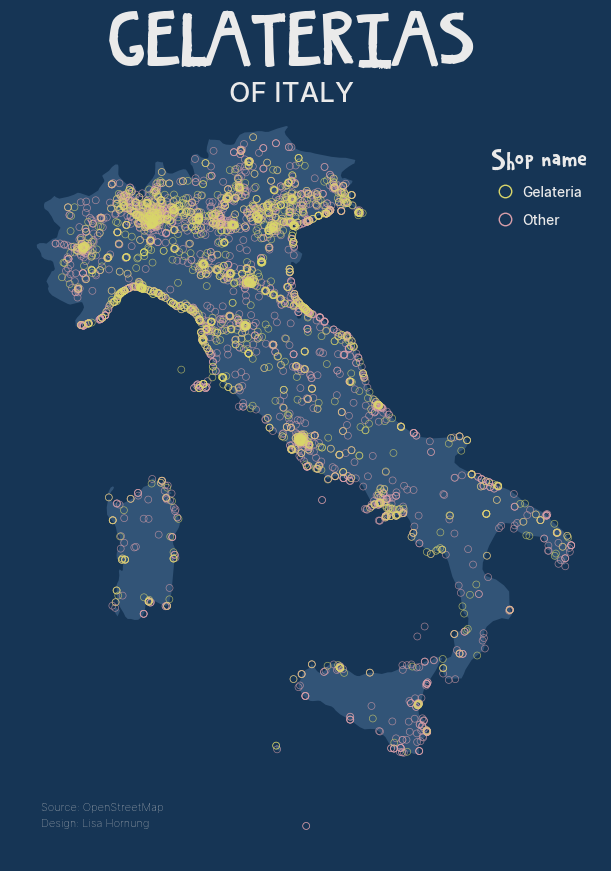

In [248]:
#plot
fig, ax = plt.subplots(figsize=(10, 10))
fig.set_facecolor(bg_color)

# ===
# Data
italy.plot(ax=ax, alpha=1, zorder=1, color="#325477")

markers = {"Gelateria": "o", "Gelato": "o", "Other":"o" } # tested different marker shapes 
for group in ["Other",  "Gelato", "Gelateria",]:
    gdf_filtered = gdf[gdf["name_group"]==group]
    gdf_filtered.plot(ax=ax, zorder=3, markersize=25, edgecolor=colrs[group], marker=markers[group], linewidth=0.5, alpha=0.7, color="None")

ax.axis("off")

# === 
# Legend
lgd = fig.add_axes([0.68, 0.7, 0.13, 0.13]) 
kw = dict(marker='o', color=bg_color ,markersize=9, alpha=1, markerfacecolor="None")
legend_elements2 = [Line2D([0], [0], markeredgecolor=colrs["Gelateria"], label="Gelateria", **kw), 
                  Line2D([0], [0], markeredgecolor=colrs["Other"], label="Other", **kw),]
L = lgd.legend(frameon=False, handles=legend_elements2, loc='center', ncol=1, handletextpad=0.2,labelspacing=1)
plt.setp(L.texts,  va="baseline",color=font_color, fontproperties=subtitle_font,size=14, )    
lgd.text(0.15,0.82,"Shop name",  va="baseline",color=font_color, fontproperties=title_font,size=12, )
lgd.axis("off")

#====
# Text
plt.figtext(0.5, 0.87 , "of Italy".upper(), fontproperties=subtitle_font, fontsize=20,  ha="center", color=font_color)
plt.figtext(0.5, 0.87+0.05, "Gelaterias".upper(), fontproperties=title_font, fontsize=30,  ha="center", color=font_color)
plt.figtext(0.25, 0.145, "Source: OpenStreetMap \nDesign: Lisa Hornung", fontproperties=label_font, fontsize=8, ha="left", color="#CECECE", linespacing=1.8)


#====
# export
plt.savefig("gelaterias-italy.png", bbox_inches='tight', dpi=300, pad_inches=0.4, facecolor=bg_color)

plt.show()